In [5]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import plotly.graph_objs as go
import pandas as pd
import pyfolio
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


def resample_to_constant_volume(df, volume_per_candle, convertTime= False):
    # sort by time
    #df = df.sort_values(by='time')
    # create cumulative volume column
    df['cumulative_volume'] = df['volume'].cumsum()
    
    #print(len(df))
    # initialize the new dataframe to hold resampled data
    resampled_df = pd.DataFrame(columns=['open', 'high', 'low', 'close','volume',"date"])
    
    start_index = 0
    end_index = 0
    cumulative_volume = 0
    for i in range(len(df)):
        cumulative_volume += df.iloc[i]['volume']
        end_index = i
        if cumulative_volume >= volume_per_candle : # make function dynamic in next round
            candle_df = df.iloc[start_index:end_index+1]
            open_price = candle_df.iloc[0]['open']
            high_price = candle_df['high'].max()
            low_price = candle_df['low'].min()
            close_price = candle_df.iloc[-1]['close']
            date_end = df.iloc[start_index]["date"]
            #x =  pd.to_datetime(datetime.strptime(mask, '%Y-%m-%d %H:%M:%S'))
            ## similarly for date_end,, this is to quickly find what 5 minute candle it belong to
            #date_end = x.strftime(f"%Y-%m-%d %H:{5*int(x.minute/5)}:%S")
            if convertTime:
                mask = df.iloc[end_index]["date"].split("+")[0]
                x =  pd.to_datetime(datetime.strptime(mask, '%Y-%m-%d %H:%M:%S'))
                ## similarly for date_end,, this is to quickly find what 5 minute candle it belong to
                temp = ("0"+str(5*int(x.minute/5)))
                date_end = x.strftime(f"%Y-%m-%d %H:{temp[-2:]}:%S")
            """resampled_df = resampled_df.append({'open': open_price, 'high': high_price, 'low': low_price, 
                                                'close': close_price, 'volume': cumulative_volume,
                                                 "date_end": date_end}, 
                                                 ignore_index=True)"""
            for i in range(int(1)):
                resampled_df = resampled_df.append({'open': open_price, 'high': high_price, 'low': low_price, 
                                                    'close': close_price, 'volume': cumulative_volume,
                                                     "date": date_end}, 
                                                     ignore_index=True)
            cumulative_volume = 0
            start_index = end_index + 1
    
    if start_index < len(df):
        candle_df = df.iloc[start_index:len(df)]
        open_price = candle_df.iloc[0]['open']
        high_price = candle_df['high'].max()
        low_price = candle_df['low'].min()
        close_price = candle_df.iloc[-1]['close']
        volume = sum(candle_df["volume"])
        date_end = df.iloc[start_index]["date"]
        #x =  pd.to_datetime(datetime.strptime(mask, '%Y-%m-%d %H:%M:%S'))
        ## similarly for date_end,, this is to quickly find what 5 minute candle it belong to
        #date_end = x.strftime(f"%Y-%m-%d %H:{5*int(x.minute/5)}:%S")
        if convertTime:
            mask = df.iloc[end_index]["date"].split("+")[0]
            x =  pd.to_datetime(datetime.strptime(mask, '%Y-%m-%d %H:%M:%S'))
            ## similarly for date_end,, this is to quickly find what 5 minute candle it belong to
            temp = ("0"+str(5*int(x.minute/5)))
            date_end = x.strftime(f"%Y-%m-%d %H:{temp[-2:]}:%S")
        resampled_df = resampled_df.append({'open': open_price, 'high': high_price, 'low': low_price, 'close': close_price, 'volume': volume,"date": str(date_end)}, ignore_index=True)

    return resampled_df
from datetime import timedelta
"""def is_body_size_greater_than_nx_average(dataframe, index,atr_multiple,look_back):
    body_sizes = (dataframe['close'] - dataframe['open']).loc[index - look_back:index].abs()
    #print(body_sizes,"efb")
    average_body_size = body_sizes.mean()
    #print(average_body_size)
    current_body_size = abs(dataframe['close'].loc[index] - dataframe['open'].loc[index])
    return current_body_size > atr_multiple * average_body_size
"""
def is_body_size_greater_than_nx_average(df, index,atr_multiple,look_back):
    body_sizes = (df['close'] - df['open']).loc[index - look_back:index-1].abs()
    average_body_size = body_sizes.mean()
    current_body_size = abs(df['close'].loc[index] - df['open'].loc[index])
    return current_body_size > atr_multiple * average_body_size


# def imbalance_from_volume(df, dateTime_index_to_check, context = {}):
    
#     ind = df[df["date"] == dateTime_index_to_check].index[0]
   
    
# #     x =  pd.to_datetime(datetime.strptime(dateTime_index_to_check, '%Y-%m-%d %H:%M:%S')+timedelta(minutes=1))
# #     endTime = x.strftime(f"%Y-%m-%d %H:%M:%S")

# #     end_index = (df[df["date"] == endTime].index)
# #     if len(end_index):
# #         end_index=end_index[0] ## corner case 15:30
# #     else:
# #         return False
    
#     volume_per_candle = df["volume"].rolling(window=200).mean().rolling(window=30).quantile(0.7).loc[ind]
#     if context:
#         vol_resampled_data1 = resample_to_constant_volume(context["resampled_candles"], volume_per_candle ,convertTime = True)
#         context["resampled_candles"] = vol_resampled_data1
   
    
# #     index_in_vol = vol_resampled_data1.index[-1]#vol_resampled_data1[vol_resampled_data1["date_end"] == dateTime_index_to_check].index[0]
#     #print(index_in_vol,"jk")
#     #print((vol_resampled_data1['volume'][index_in_vol]),volume_per_candle)
#     if(((df['volume'][ind])/volume_per_candle) > 1.3): 
#         return True
#     else :
#         return False


    
def imbalance_zone(df,dateTime_index_to_check,look_back=30):   #return imbalance zone ( price levels)
    
    index = df[df["date"] == dateTime_index_to_check].index[0]
    imbalance_candle = index 
    verify_candle  = index + 1
    
    if is_body_size_greater_than_nx_average(df,index,3,look_back):
        upper = min(min(df["low"].loc[imbalance_candle-look_back:index-1]), df["open"].loc[imbalance_candle])
        lower = max(df["high"].loc[verify_candle],df["close"].loc[imbalance_candle])

        if (upper-lower) >= 0 :
            return [ lower , upper ]  ## test in future the difference of lines more than some % of body

        else :
            return [0,0]
    return [0,0]

def filter_candles_at_index(df, index, body_threshold = 10, untouched_threshold = 20):
    # Calculate the body of the specified candle
    #index = df[df["date"] == dateTime_index_to_check].index[0]
#     print(index)
    df['body'] = df['close'] - df['open']
    body_threshold = (body_threshold+1)*df["body"].mean()
#     print(df["body"])
    body = df.loc[index]['body']
#     print(df)
    # Select only the specified candle if the body is high
    if abs(body) >= body_threshold:
        # Find the percentage of the price range covered by the body that has not been touched by the previous 10 candles
        df['body_min'] = df[['open', 'close']].min(axis=1)
        df['body_max'] = df[['open', 'close']].max(axis=1)
        df['prev_min'] = df['body_min'].shift(1).rolling(window=10).min()
        df['prev_max'] = df['body_max'].shift(1).rolling(window=10).max()
        df['price_range_untouched_min'] = df['body_min'].where(df['body_min'] > df['prev_max'], 0)
        df['price_range_untouched_max'] = df['body_max'].where(df['body_max'] < df['prev_min'], 0)
        df['price_range_untouched'] = df[['price_range_untouched_min', 'price_range_untouched_max']].max(axis=1) - df[['price_range_untouched_min', 'price_range_untouched_max']].min(axis=1)
        df['untouched_percentage'] = df['price_range_untouched'].abs() / df['body'].abs()
        # Select only the specified candle if the percentage is large
        if df.at[index, 'untouched_percentage'] >= untouched_threshold:
            return True
        else:
            return False
    else:
        return False
    
def volCheck(df,dateTime_index_to_check):
    ind = df[df["date"] == dateTime_index_to_check].index[0]
    x =  pd.to_datetime(datetime.strptime(dateTime_index_to_check, '%Y-%m-%d %H:%M:%S')+timedelta(minutes=5))
    #temp = ("0"+str(5*int((x.minute+5)/5)))
    endTime = x.strftime(f"%Y-%m-%d %H:%M:%S")
    # ind2 = df[df["date"] == endTime].index[0]
    # df = df[:ind+1]
    #print(endTime)
    end_index = (df[df["date"] == endTime].index)
    if len(end_index):
        end_index=end_index[0] ## corner case 15:30
    else:
        return False
    
    #print(data["volume"].rolling(window=80000).mean()[ind])
    #vol_resampled_data = resample_to_constant_volume(df[ind-2000:end_index],df["volume"].rolling(window=80000).mean()[ind]*1.7)
    
    volume_per_candle = df["volume"].rolling(window=8000).quantile(0.95).loc[ind]*2.5
    vol_resampled_data1 = resample_to_constant_volume(df.loc[ind-2000:end_index], volume_per_candle ,convertTime = True)
    index = vol_resampled_data1.index[-1]
    return filter_candles_at_index(vol_resampled_data1,index)

    

from collections import defaultdict

def to_intervals(data,n):   # to convert it n minute candle 
    # Read in the data from the text file
    data
    data = data.reset_index()
    data = np.array(data)
    """data = []
    name = "data_2017.txt" #input()
    with open(name, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            # Ignore the first column (stock name)
            data.append(row[1:])"""

    # Convert the data to n-minute intervals
    interval_data =  defaultdict(list)
    for row in data:
        date = row[1].split()[0]
        time = row[1].split()[1].split("+")[0][:-3]
        if time == "09:08:00":
            continue

        open_price = float(row[2])
        high_price = float(row[3])
        low_price = float(row[4])
        close_price = float(row[5])
        volume = float(row[6])
        # Extract the interval from the time and use it as the key in the dictionary
        interval = int(time[-2:]) // n
        interval = f"{time[:2]}:{interval * n:02d}"
        interval = str(date) +" " + interval + ":00"
        interval_data[interval].append((date, time, open_price, high_price, low_price, close_price, volume))

    # Calculate the final open, high, low, and close prices for each interval
    final_prices = {}
    for interval, prices in interval_data.items():
        # Unpack the tuples into separate lists for each price type
        dates, times, opens, highs, lows, closes, volume = zip(*prices)
        # The final open price is the same as the first open price in the interval
        final_open = opens[0]

        # The final high price is the highest of all the high prices in the interval
        final_high = max(highs)
        # The final low price is the lowest of all the low prices in the interval
        final_low = min(lows)
        # The final close price is the same as the last close price in the interval
        final_close = closes[-1]
        # The final volume will be the sum of all volumes of the candels
        final_volume = sum(volume)
        # Store the final prices in a tuple in the dictionary
        final_prices[interval] = (dates[0], times[0], final_open, final_high, final_low, final_close, final_volume)
    
    ws = []
    # Write the data rows
    for interval, final in final_prices.items():
        date, time, open_price, high_price, low_price, close_price, volume = final
        ws.append([date, time, interval, open_price, high_price, low_price, close_price, volume])
    return pd.DataFrame(ws,columns = ["Date", "Time", "date", "open", "high", "low", "close","volume"])
    

def handle_data(context,data_dict,i):
    ### check on index n-1::
    ## Fetch n-1 candles volume candles:::
    #data = data.reset_index()
    ## exit prev conditions
    for security in context["securities"]:
        data = data_dict[security].iloc[i-2000:i]  ## just to cut-off to current candle and remove future candles
#         print(len(data),i)
        if (((datetime(2020,1,1,datetime.strptime(data["date"].iloc[-1],"%Y-%m-%d %H:%M:%S").hour,datetime.strptime(data["date"].iloc[-1],"%Y-%m-%d %H:%M:%S").minute,0)<datetime(2020,1,1,9,30)))):
            pass
        if context["securities"][security]["canTrade"] == True:
            pass

        if context["securities"][security]["position"]:
            if data["high"].iloc[-1]>=context["securities"][security]["priceLevels"][1]:#5*data["std"].iloc[-1]+context["buy"][0]:#sum(context["profitList"])/2:#4*(context["priceLevels"][1] - context["priceLevels"][0]):
                prof = (data["close"].iloc[-1] - np.array(context["securities"][security]["buy"][0]))
                context["securities"][security]["profit"] += prof
                if prof<0:
                    context["securities"][security]["losses"] += 1   
                context["securities"][security]["profitList"].append(context["securities"][security]["profit"])
                context["securities"][security]["position"]  = 0
                context["securities"][security]["trades"] += 1
                context["securities"][security]["canTrade"] = False
                context["securities"][security]["buy"] = []
            elif data["low"].iloc[-1]<=context["securities"][security]["buy"][0] - (data["use"].iloc[-1]):#,3*(context["priceLevels"][1] - context["buy"][0])):# context["buy"][0]*10/1300:#data["close"].iloc[-1]-context["buy"]<=-2*(context["priceLevels"][1] - context["priceLevels"][0]):
                context["securities"][security]["losses"] += 1
                context["securities"][security]["position"] = 0
                context["securities"][security]["profit"] += (data["low"].iloc[-1] - np.array(context["securities"][security]["buy"][0]))
                context["securities"][security]["profitList"].append(context["securities"][security]["profit"])
                context["securities"][security]["trades"] += 1
                context["securities"][security]["canTrade"] = False
                context["securities"][security]["buy"] = []
            if context["securities"][security]["position"]==0:
                pass
                print("squaredOff",data["date"].iloc[-1],security)
            continue
        p1,p2 = 0,0
        candleToCheck = data["date"].iloc[-3]
        candleToCheck2 = data["date"].iloc[-4]
        if data['timeDiff'].iloc[-3]:
            continue
        if not (data["timeDiff"].iloc[-3]<data["timeDiff"].rolling(window=10).mean().iloc[-3-1]):
            continue

        p3,p4 = imbalance_zone(data, candleToCheck2 , 30)
        if p3!=p4:
            continue
        p1,p2 = imbalance_zone(data, candleToCheck , 30) ##zone funciton....
        if candleToCheck=="2020-01-03 09:15:00" and (security == "ACC_minute_data_with_indicators.csv" or security == "INDIGO_minute_data_with_indicators.csv" or security=="AMBUJACEM_minute_data_with_indicators.csv"):
            print(data[data["date"] == candleToCheck],security)
        if p1==p2:
            continue
        if p1<data["high"].iloc[-1]:
            continue

        context["securities"][security]["priceLevels"] = [p1,p2]

        context["securities"][security]["imbalanceCandles"].append(candleToCheck)
        context["securities"][security]["canTrade"] = True
        context["securities"][security]["currentTradeCandle"] = candleToCheck
        next_candle_strategy_trade(context["securities"][security] , data)

def buy(context,price,date = "notSet"):
    #print("buy order",date)
    context["position"] += 1
    context["buy"].append(price)
    context['stoploss'] = -100#price - (sum(context["priceLevels"])/2 - price)#price - 0.08*price   # to be change 
    context["canTrade"] = False

def next_candle_strategy_trade( context , data):
#     print("buy order",data["date"].iloc[-1])
    buy(context,data["close"].iloc[-1],data["date"].iloc[-1])
    
    
def signalTrade(context,data):
    df_vol = resample_to_constant_volume_flex(data.iloc[-1000:-1])
    
    #print(data["date"].iloc[-1],context["currentTradeCandle"])
    #print(data.index[-1],data[data["date"]==context["currentTradeCandle"]])
    if not stillTradable(data,context["currentTradeCandle"],data["date"].iloc[-1],*context["priceLevels"]):
        context["canTrade"] = False
        return

    if aosum(df_vol)["signal"].iloc[-1] :
        buy(context,data["close"].iloc[-1],data["date"].iloc[-1])

def signalTrade_(context,data):
    ## volume per candle consistent for both and imbalance
    df_vol = resample_to_constant_volume_flex(data.iloc[-2000:-1])
    #print(data["date"].iloc[-1],context["currentTradeCandle"])
    #print(data.index[-1],data[data["date"]==context["currentTradeCandle"]])
    if not stillTradable(data,context["currentTradeCandle"],data["date"].iloc[-1],*context["priceLevels"]):
        context["canTrade"] = False
        return
    else:#if buySignalFinder(df_vol)["buySignal"].iloc[-1] :
        buy(context,data["close"].iloc[-1],data["date"].iloc[-1])
        
def aosum(data):
    
    data["mid"] = (data["high"]+data["low"])/2
    data["ao"] = data["mid"].rolling(window = 5).mean() - data["mid"].rolling(window = 34).mean()
    data["signals1"] = ((data["ao"].shift(4))> (data["ao"].shift(3))) & ((data["ao"].shift(3))> (data["ao"].shift(2))) & ((data["ao"].shift(2)) < data["ao"].shift(1)) 
#     data["signals2"] = ((-data["ao"].shift(4))< (-data["ao"].shift(3))) & (-(data["ao"].shift(3))< (-data["ao"].shift(2))) & (-(data["ao"].shift(2)) > -data["ao"]) &(data["ao"]>0)
    data["signal"] = data["signals1"] 
    return data

def strategy_trade(context,df,candleToCheck):
    data = df.iloc[-50:]
    data["mid"] = (data["high"]+data["low"])/2
    data["ao"] = data["mid"].rolling(window = 5).mean() - data["mid"].rolling(window = 34).mean()
    signal = data[(data["ao"].shift(4)< data["ao"].shift(3)) & (data["ao"].shift(3)< data["ao"].shift(2)) & (data["ao"].shift(2) > data["ao"])]
    if len(signal):
        ind = signal.index[-1]
        datetime_ = signal["datetime"].loc[ind]  #latest or not ==== send data only after signal
        # datetime.datetime.strptime(datetime_,"")>candleToCheck:

        #TODO 

        buy(context,data["open"].iloc[-1],datetime)
        
    #data[data["ao"].shift(3)< data["ao"].shift(2) and data["ao"].shift(2)< data["ao"].shift(1) and data["ao"].shift(1) > data["ao"]]

def plot(df3,ds=None):
    
    # Create the candlestick chart
    fact = 1
    candlestick = go.Candlestick(x=df3.index, open=df3['open']*fact, close=df3['close']*fact, high=df3['high']*fact, low=df3['low']*fact)
#     line  = go.bar()
    # Add a line plot with secondary x-axis
    sd = []
    if ds!=None:# len(ds):
        line = go.Scatter(x=ds[ds["tt"]].index, y=ds[ds["tt"]]['close'], name='signal', xaxis='x2')
        sd.append(line)
    #line = go.Bar(x=df3.index, y=(df3['volume']/df3["volume"].mean())*data["close"].mean()/3, name='Volume')
    sd.append(candlestick)
    # Create the figure with both the candlestick and line plots
    fig = go.Figure(data=sd)

    # Update the layout to add a secondary x-axis
#     fig.update_layout(xaxis2=dict(title='signal', overlaying='x', side='top'),yaxis2 = dict(title='volume', overlaying='y', side='top'))
    fig.update_layout(xaxis_rangeslider_visible=False)

    # Show the chart
    fig.show()
    return
def plot_candlestick_with_volume(df3):
    # Create the candlestick chart
    candlestick = go.Candlestick(x=df3.index, open=df3['open'], close=df3['close'], high=df3['high'], low=df3['low'])

    # Create the bar plot for volume data
    volume_bar = go.Bar(x=df3.index, y=df3['volume'], name='Volume')

    # Create the figure with both the candlestick and bar plots
    fig = go.Figure(data=[candlestick, volume_bar])

    # Update the layout to add the volume plot below the candlestick chart
    fig.update_layout(xaxis_rangeslider_visible=False, yaxis2=dict(title='Volume', overlaying='y', side='right', showgrid=False, 
                                                                   showline=False, showticklabels=False))

    # Show the chart
    fig.show()
    return

def resample_to_constant_volume_flex(data):
    def volumeSum_threshold():
        cumsum = 0
        val = yield cumsum
        while True:
            if (cumsum < val[1] ) or ("15:29" in val[2]) and ("09:15" not in val[2]):
                cumsum += val[0]
                if ("15:29" in val[2]):
                    cumsum += val[1]
                val = yield cumsum
            else:
                cumsum = val[0]
                val = yield cumsum
    a = volumeSum_threshold()
    next(a)

    data["volume_per_candle"] = data["volume"].rolling(window=20).mean().rolling(window = 110).quantile(0.98)#.rolling(window=20).mean()
    data["volume_per_candle"].fillna(method="bfill",inplace=True)
    data["cumsum"] = data["volume"].cumsum()

    data["volume_vol"] = [a.send(v) for v in np.array(data[["volume","volume_per_candle","date"]])]
    
    data["thesholdBreak"] = data['volume_vol']>data["volume_per_candle"]
    
    data["stamp"] = data['date'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").timestamp())
    
    data["close_vol"] = data["close"]*data["thesholdBreak"].astype(int)
    data["end"] = data["stamp"]*data["thesholdBreak"].astype(int)
    
    data["open_vol"] = data["open"]*((data["thesholdBreak"]).astype(int).shift(1))
    data["open_vol"].iloc[0] = data["open"].iloc[0]
    data["open_vol"] = data['open_vol'].where(data["open_vol"] != 0, np.nan)
    data["open_vol"].fillna(method="ffill",inplace=True)
    
    
    data["start"] = data["stamp"]*((data["thesholdBreak"]).astype(int).shift(1))
    data["start"].iloc[0] = data["stamp"].iloc[0]
    data["start"] = data['start'].where(data["start"] != 0, np.nan)
    data["start"].fillna(method="ffill",inplace=True)
    
    data["close_vol"] = data['close_vol'].where(data["close_vol"] != 0, np.nan)
    data["close_vol"].iloc[-1] = data['close'].iloc[-1]
    data["close_vol"].fillna(method="bfill",inplace=True)
    
    data["end"] = data['end'].where(data["end"] != 0, np.nan)
    data["end"].iloc[-1] = data['end'].iloc[-1]
    data["end"].fillna(method="bfill",inplace=True)
    
    def high_():
        hh = 0
        val = yield hh
        while True:
            if val[0]:
                hh = max(hh,val[1])
                val = yield hh
                hh = 0
            else:
                hh = max(hh,val[1])
                val = yield hh
    h = high_()
    next(h)
    def low_():
        ll = np.inf
        val = yield ll
        while True:
            if val[0]:
                ll = min(ll,val[1])
                val = yield ll
                ll = np.inf
            else:
                ll = min(ll,val[1])
                val = yield ll
    l = low_()
    next(l)
    
    data["high_vol"]=[h.send(v) for v in np.array(data[["thesholdBreak","high"]])]
    data["low_vol"] =[l.send(v) for v in np.array(data[["thesholdBreak","low"]])]
    data["open"] = data["open_vol"]
    data["high"] = data["high_vol"]
    data["low"] = data["low_vol"]
    data["close"] = data["close_vol"]
    data["volume"] = data["volume_vol"]
    data["timeDiff"] = data["end"] - data["start"]
    
    
    return data[["date","open","high","low","close","volume_per_candle","volume","timeDiff","start","end"]][data["thesholdBreak"]]
def resample_to_constant_volume_flexPlus(data):
    cumsumli = [0]
    def temp(val,cumsumli):
        #val = yield cumsum
    #     cumsum = cumsumli[0]
        if True:
            if (cumsumli[0] < val[1] ) or ("15:29" in val[2]) and ("09:15" not in val[2]):
                cumsumli[0] += val[0]
                if ("15:29" in val[2]):
                    cumsumli[0] += val[1]
                return cumsumli[0]
            else:
                cumsumli[0] = val[0]
                return cumsumli[0]
        return cumsumli[0]

    data["volume_per_candle"] = data["volume"].rolling(window=20).mean().rolling(window = 110).quantile(0.98)#.rolling(window=20).mean()
    data["volume_per_candle"].fillna(method="bfill",inplace=True)
    data["cumsum"] = data["volume"].cumsum()

    data["volume_vol"] = [temp(v,cumsumli) for v in np.array(data[["volume","volume_per_candle","date"]])]
    
    data["thesholdBreak"] = data['volume_vol']>data["volume_per_candle"]
    
    data["stamp"] = data['date'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S").timestamp())
    
    data["close_vol"] = data["close"]*data["thesholdBreak"].astype(int)
    data["end"] = data["stamp"]*data["thesholdBreak"].astype(int)
    
    data["open_vol"] = data["open"]*((data["thesholdBreak"]).astype(int).shift(1))
    data["open_vol"].iloc[0] = data["open"].iloc[0]
    data["open_vol"] = data['open_vol'].where(data["open_vol"] != 0, np.nan)
    data["open_vol"].fillna(method="ffill",inplace=True)
    
    
    data["start"] = data["stamp"]*((data["thesholdBreak"]).astype(int).shift(1))
    data["start"].iloc[0] = data["stamp"].iloc[0]
    data["start"] = data['start'].where(data["start"] != 0, np.nan)
    data["start"].fillna(method="ffill",inplace=True)
    
    data["close_vol"] = data['close_vol'].where(data["close_vol"] != 0, np.nan)
    data["close_vol"].iloc[-1] = data['close'].iloc[-1]
    data["close_vol"].fillna(method="bfill",inplace=True)
    
    data["end"] = data['end'].where(data["end"] != 0, np.nan)
    data["end"].iloc[-1] = data['end'].iloc[-1]
    data["end"].fillna(method="bfill",inplace=True)
    
    hh_ = [0]
    def high_2(val,hh):
        if True:
            if val[0]:
                hh[0] = max(hh[0],val[1])
                temp = hh[0]
                hh[0] = 0
                return temp
            else:
                hh[0] = max(hh[0],val[1])
                return hh[0]
        return hh[0]
    
    ll_ = [np.inf]
    def low_2(val,ll):
        if True:
            if val[0]:
                ll[0] = min(ll[0],val[1])
                temp = ll[0]
                ll[0] = np.inf
                return temp
            else:
                ll[0] = min(ll[0],val[1])
                return ll[0]
        return ll[0]
    
    
    data["high_vol"]=[high_2(v,hh_) for v in np.array(data[["thesholdBreak","high"]])]  #[h.send(v) for v in np.array(data[["thesholdBreak","high"]])]
    data["low_vol"] =[low_2(v,ll_) for v in np.array(data[["thesholdBreak","low"]])]
    data["open"] = data["open_vol"]
    data["high"] = data["high_vol"]
    data["low"] = data["low_vol"]
    data["close"] = data["close_vol"]
    data["volume"] = data["volume_vol"]
    data["timeDiff"] = data["end"] - data["start"]
    
    
    return data[["date","open","high","low","close","volume_per_candle","volume","timeDiff","start","end"]][data["thesholdBreak"]]

def buySignalFinder(df):
    df["checkSwing"] =  (df['high'] > df['high'].shift(1)) & (df['high'] > df['high'].shift(-1)) & (df['low'] > df['low'].shift(1)) & (df['low'] > df['low'].shift(-1))
    df["index"] = (df["checkSwing"].astype(int))*(df["high"])
    df["index"] = df['index'].where(df['index'] != 0, np.nan)
    df["index"].fillna(method="ffill",inplace=True)
    df["pivotHi"] = df["index"].fillna(0)
    df["buySignal"] = (df["close"]>df["pivotHi"]) & df["pivotHi"]
    return df[["buySignal","pivotHi"]]


def stillTradable(df,imbalance_candle,current_candle, lower_range,upper_range,stop_loss = 0.00,risk_multi=0.3):
    return True
    imbalance_candle_ind = df[df["date"] == imbalance_candle].index[0]
    current_candle_ind = df[df["date"] == current_candle].index[0]

    between_candels = df.loc[imbalance_candle_ind+1:current_candle_ind]

    highest_price_between = between_candels['high'].max()

    if highest_price_between < lower_range :
        # print('highest_price_between < lower_range')
        current_close =df.loc[current_candle_ind]['close']

        target_price = (upper_range+lower_range)/2
        target_distance = target_price - current_close

        # stop_loss = current_close =df.iloc[current_candle_ind]['close']*.002
        return True
        if target_distance > risk_multi*(stop_loss)*current_close:
            # print("target_distance < risk_multi*stop_loss")
            return True
        else:
            print('target & SL not n times')
            return False
    return False
def stillTradable_forBacktest(df,imbalance_candle,current_candle,lower_range,upper_range,stop_loss = 0.00,risk_multi=2):

    imbalance_candle_ind = df[df["date"] == imbalance_candle].index[0]
    current_candle_ind = df[df["date"] == current_candle].index[0]

    between_candels = df.loc[imbalance_candle_ind+1:current_candle_ind]

    highest_price_between = between_candels['high'].max()

    if highest_price_between < lower_range :
        # print('highest_price_between < lower_range')
        current_close =df.loc[current_candle_ind]['close']

        target_price = (upper_range+lower_range)/2
        target_distance = target_price - current_close

        # stop_loss = current_close =df.iloc[current_candle_ind]['close']*.002

        if target_distance > risk_multi*(stop_loss)*current_close:
            # print("target_distance < risk_multi*stop_loss")
            return True
        else:
            print('target & SL not n times')
            return False
    return False



print("adv")

#run 
#data = pd.read_csv("data.")
# data = data.reset_index()
context = {}
context["securities"] = {}#defaultdict(sd)
data_dict = {}
securities = ["ACC_minute_data_with_indicators.csv"]
#               ,"ADANIENT_minute_data_with_indicators.csv","ASIANPAINT_minute_data_with_indicators.csv","BIOCON_minute_data_with_indicators.csv","BAJAJFINSV_minute_data_with_indicators.csv","AUROPHARMA_minute_data_with_indicators.csv"]
for security in securities:
    data = pd.read_csv(security, usecols = ["date","open","high","low","close","volume"]).iloc[150971:]
    print("data_read")
    data["date"]=data["date"].apply(lambda x:datetime.strptime(x,"%Y-%m-%d %H:%M:%S+05:30").strftime("%Y-%m-%d %H:%M:%S"))
    #data2 = resample_to_constant_volume_flexPlus(data.copy())
    #data["std"] = data["close"].rolling(window=30).std()
    data = resample_to_constant_volume_flexPlus(data.copy())
    data = data.reset_index()
    data['std'] = data['close'].rolling(15).std()
    data["use"] = data['high'] - data["close"].rolling(30).mean() - 2*data['std']
    data_dict[security] = data
    perSec = {}
    perSec["profit"] = 0
    perSec["profitList"] = []#.append(context["profit"])
    perSec["losses"] = 0

    perSec["position"]  = 0
    perSec["trades"] = 0
    perSec["buy"] = []
    perSec['stoploss'] = 0# price - 0.02*price   # to be change 
    perSec["priceLevels"] = [0,0]
    perSec["imbalanceCandles"] = []
    # i = data.index[0]+4#int((249971-1000)/1)#data.index[0]+10000
    # perSec['resampled_candles'] = data.loc[i-200:i+1]
    perSec["volumeCandles"] = []
    perSec["canTrade"] = False
    perSec["currentTradeCandle"] = ""
    context["securities"][security] = perSec


adv
data_read


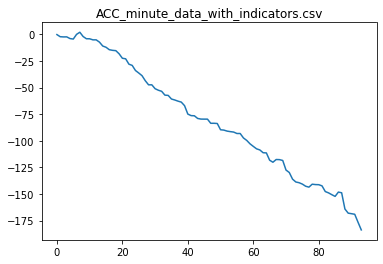

In [8]:
for sec in context["securities"]:
    plt.plot( (range(len(context["securities"][sec]["profitList"]))),context["securities"][sec]["profitList"])
    plt.title(sec)
    plt.show()

In [3]:
# data_dict["AMBUJACEM_minute_data_with_indicators.csv"]

,index,date,open,high,low,close,volume_per_candle,volume,timeDiff,start,end,std
0,150993,2016-11-03 13:37:00,239.50,240.75,238.10,239.60,212604.712,215360.0,1320.0,1.478159e+09,1.478160e+09,NaN
1,151010,2016-11-03 13:54:00,239.55,241.40,239.50,240.60,212604.712,212960.0,960.0,1.478160e+09,1.478161e+09,NaN
2,151022,2016-11-03 14:06:00,240.60,240.80,239.50,239.60,212604.712,235310.0,660.0,1.478162e+09,1.478162e+09,NaN
3,151030,2016-11-03 14:14:00,239.60,239.70,237.50,238.00,212604.712,222851.0,420.0,1.478162e+09,1.478163e+09,NaN
4,151057,2016-11-03 14:41:00,238.00,239.30,237.25,237.60,212604.712,228090.0,1560.0,1.478163e+09,1.478164e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
166929,665751,2022-10-24 18:40:00,518.05,518.20,516.50,516.95,118446.480,124890.0,300.0,1.666617e+09,1.666617e+09,2.750164
166930,665761,2022-10-24 18:50:00,516.95,517.25,516.10,516.80,118446.480,120256.0,540.0,1.666617e+09,1.666618e+09,2.647957
166931,665771,2022-10-24 19:00:00,517.10,517.50,516.75,517.20,89681.746,104994.0,540.0,1.666618e+09,1.666618e+09,2.682181
166932,665776,2022-10-24 19:05:00,517.40,517.40,516.10,516.10,80817.698,103302.0,240.0,1.666618e+09,1.666618e+09,2.686463


In [4]:
[handle_data(context,data_dict,i) for i in range(2000,120000)]

squaredOff 2016-12-07 13:45:00 CHOLAFIN_minute_data_with_indicators.csv
squaredOff 2016-11-30 09:15:00 ITC_minute_data_with_indicators.csv
squaredOff 2016-12-08 09:16:00 CHOLAFIN_minute_data_with_indicators.csv
squaredOff 2016-11-30 15:29:00 ITC_minute_data_with_indicators.csv
squaredOff 2016-12-01 14:41:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2016-12-16 14:38:00 CHOLAFIN_minute_data_with_indicators.csv
squaredOff 2016-12-02 12:40:00 ITC_minute_data_with_indicators.csv
squaredOff 2016-12-02 14:55:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2016-12-08 09:25:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2016-12-19 14:58:00 ACC_minute_data_with_indicators.csv
squaredOff 2016-12-19 09:16:00 ITC_minute_data_with_indicators.csv
squaredOff 2017-01-02 09:37:00 CHOLAFIN_minute_data_with_indicators.csv
squaredOff 2016-12-21 15:29:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2016-12-19 13:15:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff

squaredOff 2017-06-20 15:29:00 ITC_minute_data_with_indicators.csv
squaredOff 2017-07-26 09:23:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2018-05-30 09:15:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2017-08-10 13:53:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2017-07-03 15:18:00 ITC_minute_data_with_indicators.csv
squaredOff 2017-11-08 15:27:00 CHOLAFIN_minute_data_with_indicators.csv
squaredOff 2017-08-01 15:03:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2017-08-10 14:31:00 ACC_minute_data_with_indicators.csv
squaredOff 2018-06-04 15:10:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2017-07-07 11:23:00 ITC_minute_data_with_indicators.csv
squaredOff 2018-06-13 14:56:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2017-07-17 12:18:00 ITC_minute_data_with_indicators.csv
squaredOff 2017-12-05 10:35:00 CHOLAFIN_minute_data_with_indicators.csv
squaredOff 2018-06-20 10:18:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2017-08-2

squaredOff 2018-01-25 13:45:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2018-01-25 15:07:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2018-01-30 14:25:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2018-12-06 10:44:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2018-02-01 09:43:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2018-02-26 15:23:00 ACC_minute_data_with_indicators.csv
squaredOff 2018-06-27 15:00:00 CHOLAFIN_minute_data_with_indicators.csv
squaredOff 2018-02-14 14:00:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2017-12-29 09:27:00 ITC_minute_data_with_indicators.csv
squaredOff 2018-03-28 09:37:00 ACC_minute_data_with_indicators.csv
squaredOff 2019-01-04 10:57:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2018-07-18 14:03:00 CHOLAFIN_minute_data_with_indicators.csv
squaredOff 2018-02-28 13:01:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2018-01-12 13:55:00 ITC_minute_data_with_indicators.csv
squa

squaredOff 2018-06-27 14:17:00 ITC_minute_data_with_indicators.csv
squaredOff 2018-10-22 14:28:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2018-10-23 09:46:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2018-10-24 11:30:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2018-10-25 09:38:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2019-07-24 10:23:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2018-10-19 13:19:00 ACC_minute_data_with_indicators.csv
squaredOff 2018-10-26 09:36:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2018-07-03 15:10:00 ITC_minute_data_with_indicators.csv
squaredOff 2018-10-23 13:08:00 ACC_minute_data_with_indicators.csv
squaredOff 2019-07-29 09:22:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2019-07-31 09:38:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2018-11-02 15:28:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2019-08-01 15:02:00 INDIGO_minute_data_with_indicators.csv
squaredOff 201

squaredOff 2018-12-10 13:56:00 ITC_minute_data_with_indicators.csv
squaredOff 2019-02-14 11:12:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2019-02-15 09:27:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2019-04-05 09:15:00 ACC_minute_data_with_indicators.csv
squaredOff 2019-04-24 10:56:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2019-08-28 15:05:00 CHOLAFIN_minute_data_with_indicators.csv
squaredOff 2020-01-14 15:16:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2019-02-19 15:22:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2020-01-22 09:16:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2019-04-24 11:44:00 ACC_minute_data_with_indicators.csv
squaredOff 2019-09-17 14:23:00 CHOLAFIN_minute_data_with_indicators.csv
squaredOff 2019-05-13 09:47:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2018-12-31 09:16:00 ITC_minute_data_with_indicators.csv
squaredOff 2020-01-31 09:15:00 INDIGO_minute_data_with_indicators.csv
squaredOff

squaredOff 2019-08-27 14:58:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2020-04-01 09:57:00 CHOLAFIN_minute_data_with_indicators.csv
squaredOff 2019-10-17 12:39:00 ACC_minute_data_with_indicators.csv
squaredOff 2019-05-28 09:24:00 ITC_minute_data_with_indicators.csv
squaredOff 2020-07-21 14:43:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2019-05-31 09:16:00 ITC_minute_data_with_indicators.csv
squaredOff 2020-07-22 09:57:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2019-05-31 13:12:00 ITC_minute_data_with_indicators.csv
squaredOff 2019-05-31 15:08:00 ITC_minute_data_with_indicators.csv
squaredOff 2020-04-13 11:24:00 CHOLAFIN_minute_data_with_indicators.csv
squaredOff 2019-10-31 09:15:00 ACC_minute_data_with_indicators.csv
squaredOff 2020-07-24 09:15:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2020-07-24 11:07:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2019-06-06 13:43:00 ITC_minute_data_with_indicators.csv
squaredOff 2019-11-05 14:20:00 AC

squaredOff 2021-01-28 09:25:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2020-06-09 14:52:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2020-06-10 14:19:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2019-12-02 15:19:00 ITC_minute_data_with_indicators.csv
squaredOff 2020-10-07 09:50:00 CHOLAFIN_minute_data_with_indicators.csv
squaredOff 2019-12-09 10:08:00 ITC_minute_data_with_indicators.csv
squaredOff 2020-03-17 13:45:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2020-03-18 09:15:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2021-02-16 13:20:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2021-02-17 09:24:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2021-02-19 14:10:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2020-06-24 15:17:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2020-06-29 09:54:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2020-03-30 09:31:00 BHARTIARTL_minute_data_with_indicators.csv


squaredOff 2021-10-25 10:13:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2020-09-30 15:16:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2020-12-21 14:41:00 ACC_minute_data_with_indicators.csv
squaredOff 2021-10-28 15:08:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2021-02-09 09:15:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2020-07-09 12:17:00 ITC_minute_data_with_indicators.csv
squaredOff 2020-10-12 15:26:00 BHARTIARTL_minute_data_with_indicators.csv
squaredOff 2021-02-15 09:15:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2020-07-14 13:23:00 ITC_minute_data_with_indicators.csv
squaredOff 2021-01-05 13:40:00 ACC_minute_data_with_indicators.csv
squaredOff 2020-07-16 11:43:00 ITC_minute_data_with_indicators.csv
squaredOff 2021-02-18 09:36:00 AMBUJACEM_minute_data_with_indicators.csv
squaredOff 2021-11-18 15:29:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2021-11-22 11:46:00 INDIGO_minute_data_with_indicators.csv
squaredOff 2021-11

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [7]:
[handle_data(context,data_dict,i) for i in range(2000,75000)]

squaredOff 2016-12-19 14:57:00 ACC_minute_data_with_indicators.csv
squaredOff 2017-01-04 10:46:00 ACC_minute_data_with_indicators.csv
squaredOff 2017-01-12 13:24:00 ACC_minute_data_with_indicators.csv
squaredOff 2017-01-12 13:26:00 ACC_minute_data_with_indicators.csv
squaredOff 2017-02-10 13:44:00 ACC_minute_data_with_indicators.csv
squaredOff 2017-02-14 09:19:00 ACC_minute_data_with_indicators.csv
squaredOff 2017-02-22 13:12:00 ACC_minute_data_with_indicators.csv
squaredOff 2017-04-03 15:14:00 ACC_minute_data_with_indicators.csv
squaredOff 2017-05-02 09:19:00 ACC_minute_data_with_indicators.csv
squaredOff 2017-05-15 13:46:00 ACC_minute_data_with_indicators.csv
squaredOff 2017-05-18 15:03:00 ACC_minute_data_with_indicators.csv
squaredOff 2017-06-02 15:06:00 ACC_minute_data_with_indicators.csv
squaredOff 2017-06-06 14:25:00 ACC_minute_data_with_indicators.csv
squaredOff 2017-07-18 14:40:00 ACC_minute_data_with_indicators.csv
squaredOff 2017-07-20 12:10:00 ACC_minute_data_with_indicators

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

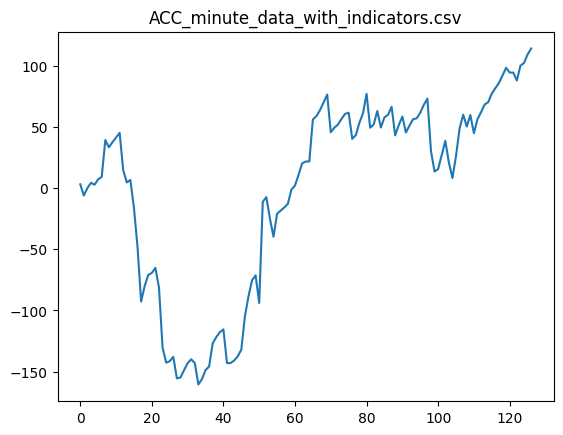

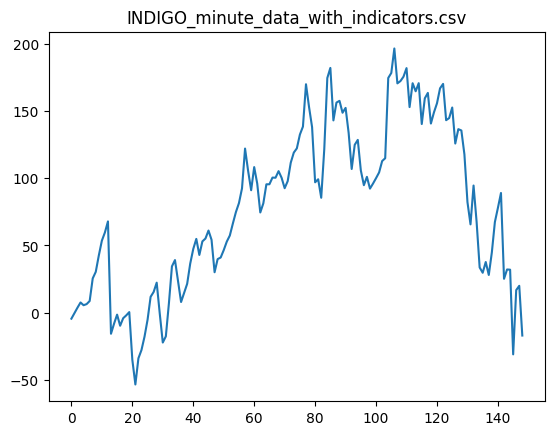

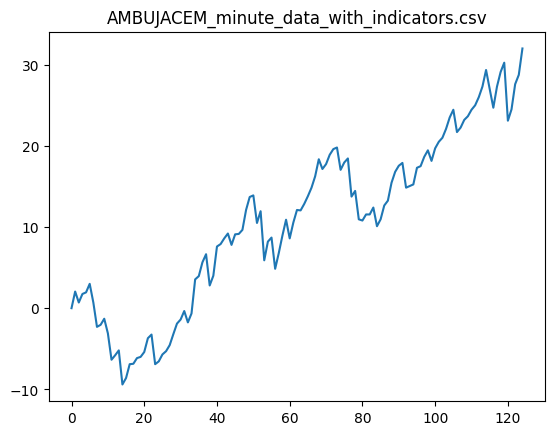

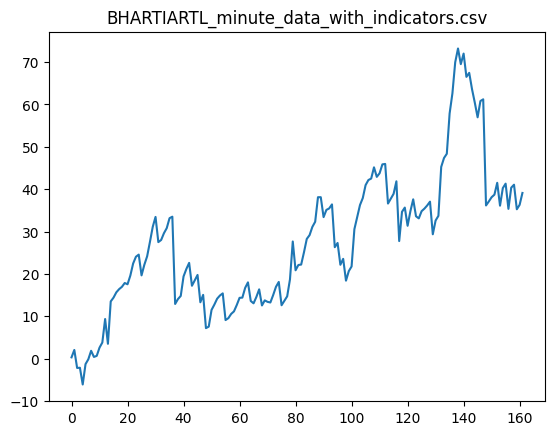

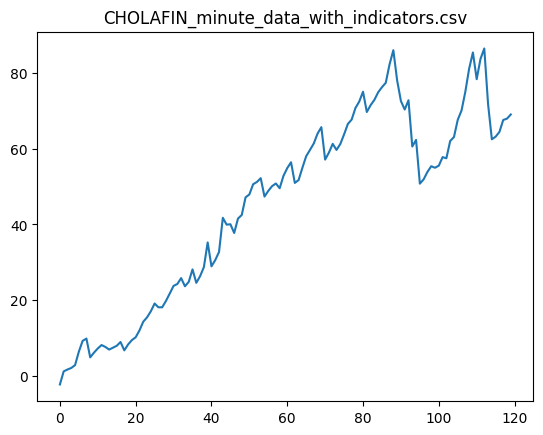

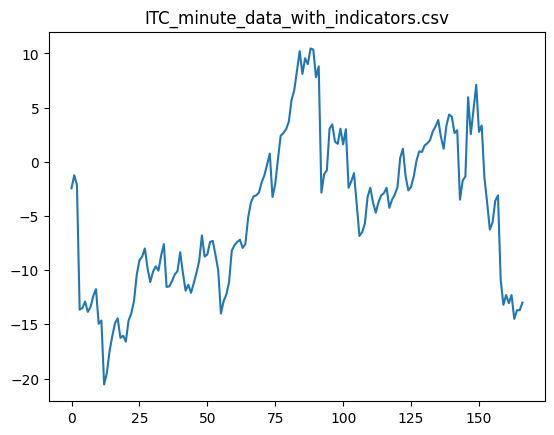

In [11]:
for sec in context["securities"]:
    plt.plot( (range(len(context["securities"][sec]["profitList"]))),context["securities"][sec]["profitList"])
    plt.title(sec)
    plt.show()